In [1]:
%matplotlib inline
from __future__ import print_function, division
path = "data/baidu/"
#path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink
import cv2

Using TensorFlow backend.


In [2]:
train_path = 'data/baidu/image_contest_level_2_train/'
label_exp_count = load_array('data/baidu/label_exp_num.data')

In [3]:
label_exp_files = []
for i, cnt in enumerate(label_exp_count):
    for c in range(cnt):
        label_exp_files.append('{}-{}-{}.png'.format(i, cnt-c, cnt))

In [4]:
label_path = 'data/baidu/level2_labels.txt'
raw_label_list = []
with open(label_path) as f:
    raw_label_list = f.readlines()
raw_label_list = [x.strip() for x in raw_label_list]
label_exp_num_length= []
exp_labels = []
exp_lens =[]
for line in raw_label_list:
    parts = line.split(' ')
    exprs = parts[0]
    result = parts[1]
    label_exp_num_length.append(len(exprs.split(';')))
    for exp in exprs.split(';'):
        exp_labels.append(exp.decode('utf8'))
        exp_lens.append(len(exp.decode('utf8')))


In [5]:
short_idxs = []
long_idxs = []
cursor = 0
for cnt in label_exp_count:
    for i in range(cnt):
        if i==cnt-1:
            long_idxs.append(cursor+i)
        else: 
            short_idxs.append(cursor+i)
    cursor = cursor + cnt
short_idxs = np.asarray(short_idxs)
long_idxs = np.asarray(long_idxs)

In [6]:
class DataGenator(keras.callbacks.Callback):
    
    def __init__(self, idxs, width, height):
        self.width = width
        self.height = height
        self.idxs = idxs
        self.label_length = max(np.asarray(exp_lens)[self.idxs])

        mask = np.random.rand(len(self.idxs)) < 0.9
        self.trn_idxs = self.idxs[mask]
        self.val_idxs = self.idxs[~mask]
        
        self.token_counts = {}
        for exp in np.asarray(exp_labels)[self.idxs]:
            for c in exp:
                if c in self.token_counts:
                    self.token_counts[c] += 1
                else:
                    self.token_counts[c] = 1
        self.tokens = sorted(self.token_counts.keys()) + ['N']
        self.zero_idx = len(self.tokens)-1
        
        
        self.token_idxs = dict()
        for i,token in enumerate(self.tokens):
            self.token_idxs[token] = i
            
        #所有的label都转化  但不会全部用上  用不上的为空
        self.actual_labels = np.full((len(exp_labels), self.label_length), self.zero_idx)
        for idx in idxs:
            for i, token in enumerate(exp_labels[idx]):
                self.actual_labels[idx][i] = self.token_idxs[token]
            
    def get_batch(self, batch_size, idxs, shuffle=True):
        if shuffle:  
            idxs = np.random.permutation(idxs)
        cur = 0
        idxs_len = len(idxs)
        while True:
            out = []
            next_cur = cur + batch_size
            if next_cur < idxs_len:
                out = idxs[cur: next_cur]
                cur = next_cur
            else:
                exceed = next_cur - idxs_len
                out = idxs[cur: idxs_len]
                if shuffle:  idxs = np.random.permutation(idxs)
                out = np.concatenate([out, idxs[0: exceed]]) 
                cur = exceed
            yield self.fetch_img_by_idxs(out), np.expand_dims(np.asarray(self.actual_labels)[out], axis=-1)
        
    def fetch_img_by_idxs(self, idxs):
        imgs = []
        for f in np.array(label_exp_files)[idxs]:
            img = cv2.imread(train_path+f)
            img = cv2.resize(img, (self.width, self.height), interpolation = cv2.INTER_LINEAR)
            img = np.transpose(np.asarray(img), (1, 0, 2))
            imgs.append(img)
        return np.array(imgs)
    
    
    def to_pretty_label(self, label):
        l = label.flatten().astype('int')
        s =''
        for token in l:
            if token != self.zero_idx:
                 s = s+self.tokens[token]
        return s    

In [7]:
img_gen = DataGenator(idxs=np.arange(len(exp_labels)), width=300, height=45)
def generate_save_data():
    da = img_gen.get_batch(len(long_idxs), long_idxs, shuffle=False)
    all_long_imgs, all_long_labels = next(da)
    save_array('all_long_imgs.dat', all_long_imgs)
    save_array('all_long_labels.dat', all_long_labels)

In [8]:
def show_data(x, y):  
    for i in range(len(x)):
        print(img_gen.to_pretty_label(y[i]))
        plots(np.expand_dims(x[i], axis=0))

In [9]:
def predict(val_imgs):
    preds = model.predict(val_imgs)
    predict_labels = np.expand_dims(np.argmax(preds, axis=-1), axis=-1)

    for i in range(len(val_imgs)):
        print(short_img_gen.to_pretty_label(predict_labels[i]))
        plots(np.expand_dims(val_imgs[i], axis=0))
    

In [10]:
imgs = load_array('data/baidu/trn_imgs.dat')
labels = load_array('data/baidu/trn_labels.dat')

In [11]:
def gen_label_length(labels):
    label_lengths = np.zeros((len(labels), 1))
    for i in range(len(labels)):
        label_lengths[i] = len(np.where(np.array(labels[i]) != img_gen.zero_idx)[0])
    return label_lengths.astype('uint8')

In [12]:
idxs = np.random.permutation(imgs.shape[0])
mask = np.random.rand(imgs.shape[0]) < 0.9
trn_idxs = idxs[mask]
val_idxs = idxs[~mask]


x_trn = imgs[trn_idxs]
x_trn = np.transpose(x_trn, (0, 3, 2, 1))
y_trn = np.reshape(labels[trn_idxs], (-1, img_gen.label_length))
#y_trn[np.where(y_trn==img_gen.zero_idx)] = 0
y_trn_raw = labels[trn_idxs]


x_val = imgs[val_idxs]
x_val = np.transpose(x_val, (0, 3, 2, 1))

y_val = np.reshape(labels[val_idxs], (-1, img_gen.label_length))
y_label_length = gen_label_length(y_val)
y_val[np.where(y_val==img_gen.zero_idx)] = 0
y_val_raw = labels[val_idxs]


In [13]:
x_trn.shape, y_trn.shape, x_val.shape, y_val.shape

((215589, 300, 45, 3), (215589, 30), (23791, 300, 45, 3), (23791, 30))

In [14]:
y_trn[1],y_val[0],y_label_length[:10]

(array([23, 16,  9, 11,  9, 12, 13, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
        43, 43, 43, 43, 43, 43, 43]),
 array([ 0, 12, 14,  6, 15,  8,  3,  0, 11,  6,  7,  9, 12,  4, 32,  1,  1,  4, 35,  5, 11, 10, 14,
        10,  7,  0,  0,  0,  0,  0]),
 array([[25],
        [24],
        [27],
        [ 7],
        [ 7],
        [ 7],
        [25],
        [ 7],
        [ 7],
        [ 7]], dtype=uint8))

In [14]:
def map2seq(x):
    return K.reshape(K.permute_dimensions(x, (0, 3, 2, 1)), (x.shape[0], x.shape[-1], -1))

In [15]:
def map2seq_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4  # only valid for 4D tensors
    return (shape[0], shape[-1], shape[1]*shape[2])

In [16]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

 zoom_range=0.05, shear_range=0.05, channel_shift_range=20,
                             rotation_range=5, height_shift_range=0.03, width_shift_range=0.03

In [17]:
batch_size = 64
da = image.ImageDataGenerator()
x_trn_len = len(x_trn)//64*64
trn_batches = da.flow(x_trn[:x_trn_len], y_trn[:x_trn_len], batch_size=batch_size, shuffle=True)


In [18]:
def trn_gen():
    #减2是因为进入ctc时  已经丢弃了2帧
    input_length = np.zeros([batch_size, 1]) + (ctc_time_lenght - 2)
    while True:
        x, y = next(trn_batches)
        label_length = gen_label_length(y)
        y[np.where(y==img_gen.zero_idx)] = 0
        yield [x, y, input_length, label_length], np.zeros([batch_size])

In [3]:
def val_data():
    size = len(x_val)
    input_length = np.zeros([size, 1]) + (ctc_time_lenght - 2)
    return [x_val, y_val, input_length, y_label_length], np.zeros([size])

In [20]:
batches = trn_gen()
def inspect_trn_data():
    batch = next(batches)[0]
    img = batch[0][0]
    label = batch[1][0]
    il =batch[2][0]
    ll  =batch[3][0]
    print(img.shape)
    plots(np.expand_dims(np.transpose(img, (1,0,2)), axis=0))
    print(label)
    print(img_gen.to_pretty_label(label))
    print(il)
    print(ll)

In [21]:
inspect_trn_data()

NameError: global name 'ctc_time_lenght' is not defined

In [23]:
def is_long_label(label):
    return not(len(np.where(label > 0)[0]) < 10)

In [49]:
def evaluate(base_model, batch_num=None):
    [X_test, y_test, _, _], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    out = base_model.predict(X_test[:batch_num])
    correct_number = 0
    correct_long_n = 0
    total_long_n = 0
    correct_short_n = 0
    total_short_n = 0
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = np.array([k for k, g in itertools.groupby(out_best)])
        l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
        if img_gen.label_length - len(l) < 0:
            print(l)
        pred = np.lib.pad(l, ((0, abs(img_gen.label_length - len(l)))),  mode='constant', constant_values=0)
        equal = np.array_equal(pred, y_test[j])
        is_long = is_long_label(y_test[j])
        if is_long:
            total_long_n=total_long_n+1
        else:
            total_short_n=total_short_n+1
        if equal:
            correct_number = correct_number+1
            if is_long:
                correct_long_n=correct_long_n+1
            else:
                correct_short_n=correct_short_n+1
    l = 0
    s = 0
    if total_long_n>0: l=correct_long_n/total_long_n
    if total_short_n>0: s=correct_short_n/total_short_n
    
    return correct_number/batch_num, s, l

In [ ]:
def evaluate2(model, batch_num=10):
    
    [X_test, y_test, _, _], _  = val_data()
    y_pred = base_model.predict(X_test)
    shape = y_pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
    if out.shape[1] == 4:
        batch_acc += ((y_test == out).sum(axis=1) == 4).mean()


In [2]:
[X_test, y_test, _, _], _  = val_data()
pred = base_model.predict(X_test[:1])
shape = pred[:,2:,:].shape

NameError: name 'val_data' is not defined

In [90]:
K.set_learning_phase(0)

In [93]:
[X_test, y_test, _, _], _  = val_data()
pred = base_model.predict(X_test[:1])
shape = pred[:,2:,:].shape
out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]

InvalidArgumentError: You must feed a value for placeholder tensor 'the_input_6' with dtype float
	 [[Node: the_input_6 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: ToInt32_21/_655 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_377_ToInt32_21", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'the_input_6', defined at:
  File "/home/viiv/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/viiv/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-91-6dda82e87064>", line 3, in <module>
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 1198, in Input
    input_tensor=tensor)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 1116, in __init__
    name=self.name)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 321, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1332, in placeholder
    name=name)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1748, in _placeholder
    name=name)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'the_input_6' with dtype float
	 [[Node: the_input_6 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: ToInt32_21/_655 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_377_ToInt32_21", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [113]:
evaluate(base_model)

[ 0 15 14  7 10 13  4 12  6  6 10 14 14  1  2  0 17  5 11  7  6 15  6 12  2  2 13 11 13  1 14  1]
[ 0  8  9 10 10  7  4  0 13  7  8 14 13  6  4 17  5 15  6 12 10  6 12  1  1  1  7 12  6  7  1]


0.15456966871982686

In [68]:
out_best = np.array([1,2])
l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
np.lib.pad(l, ((0, img_gen.label_length - len(l))),  mode='constant', constant_values=0)

array([1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [132]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc, s, l = evaluate(base_model)
        self.accs.append(acc)
        acc = acc *100
        s = s * 100
        l = l * 100
        print(' acc: %f%%'%acc)
        print(' short: %f%%'%s)
        print(' l: %f%%'%l)
        
        if acc > 70:
            model.save_weights('v{}.wgt'.format(epoch))

evaluator = Evaluate()

In [141]:
ctc_time_lenght = 73
input_shape=( img_gen.width, img_gen.height, 3)
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = BatchNormalization(axis=1)

inner = Convolution2D(64, 3, 3,  activation='relu')(input_data)
inner = BatchNormalization(axis=1)(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(128, 3, 3,  activation='relu')(inner)
inner = BatchNormalization(axis=1)(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(256, 3, 3,  activation='relu', border_mode='same')(inner)
inner = Convolution2D(256, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization(axis=1)(inner)
inner = MaxPooling2D((1,2))(inner)

inner = Convolution2D(512, 3, 3,  activation='relu', border_mode='same')(inner)
inner = Convolution2D(512, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization(axis=1)(inner)
inner = MaxPooling2D((1,2))(inner)



#inner = Lambda(map2seq, output_shape=map2seq_output_shape)(inner)
inner = Reshape((ctc_time_lenght, -1))(inner)

inner = Dense(128, activation='relu')(inner)

inner = Bidirectional(GRU(256, return_sequences=True, inner_init='identity'), merge_mode='sum')(inner)
inner = Bidirectional(GRU(256, return_sequences=True, inner_init='identity'), merge_mode='concat')(inner)


y_pred = Dense(len(img_gen.tokens), activation='softmax')(inner)

base_model = Model(input=input_data, output=y_pred)

labels = Input(name='the_labels', shape=(img_gen.label_length,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64') 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model([input_data, labels, input_length, label_length], loss_out)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 300, 45, 3)    0                                            
____________________________________________________________________________________________________
convolution2d_146 (Convolution2D (None, 298, 43, 64)   1792        the_input[0][0]                  
____________________________________________________________________________________________________
batchnormalization_121 (BatchNor (None, 298, 43, 64)   1192        convolution2d_146[0][0]          
____________________________________________________________________________________________________
maxpooling2d_97 (MaxPooling2D)   (None, 149, 21, 64)   0           batchnormalization_121[0][0]     
___________________________________________________________________________________________

In [142]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam())

In [130]:
x_trn_len = len(x_trn)//64*64
x_val_len = len(x_val)//64*64

In [ ]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

model.optimizer.lr=0.0001
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/20
215488/215552 [============================>.] - ETA: 0s - loss: 33.5817 acc: 0.000000%
 short: 0.000000%
 l: 0.000000%
215552/215552 [==============================] - 2635s - loss: 33.5811 - val_loss: 29.3383
Epoch 2/20
215488/215552 [============================>.] - ETA: 0s - loss: 1.1806 acc: 80.862511%
 short: 94.070480%
 l: 58.960894%
215552/215552 [==============================] - 2622s - loss: 1.1804 - val_loss: 0.9206
Epoch 5/20
  5568/215552 [..............................] - ETA: 2437s - loss: 0.8433

KeyboardInterrupt: 

In [133]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/20
215488/215552 [============================>.] - ETA: 0s - loss: 1.1353[ 0 13 10  7 11  6  4  0  9  6  8  8  7 10  4 34  5 12  9  6  8 10  1  1  4  7 15 13 13 13 10]
 acc: 78.626371%
 short: 92.527458%
 l: 55.575419%
215552/215552 [==============================] - 2650s - loss: 1.1352 - val_loss: 1.0615
Epoch 2/20
215488/215552 [============================>.] - ETA: 0s - loss: 0.8994 acc: 83.413896%
 short: 95.034027%
 l: 64.145251%
215552/215552 [==============================] - 2651s - loss: 0.8993 - val_loss: 0.7757
Epoch 3/20
215488/215552 [============================>.] - ETA: 0s - loss: 0.7737 acc: 84.170485%
 short: 95.566337%
 l: 65.273743%
215552/215552 [==============================] - 2654s - loss: 0.7736 - val_loss: 0.7267
Epoch 4/20
215488/215552 [============================>.] - ETA: 0s - loss: 0.6159[ 0  0  9 12  6 14 13  2 13 15 10  8  6  1  3 25  5  8 11  7 15 12  1  4  7  6  6  6  6  6  1]
 acc: 84.800975%
 short: 95.067718%
 l: 67.776536%
215552/2155

KeyboardInterrupt: 

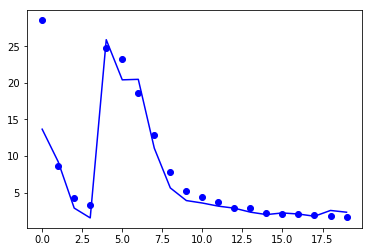

In [134]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')

plt.show()


In [ ]:
model.optimizer.lr=0.00001
history3 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.5804[ 0 39  5 13 13  7 12  9  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0 14 10 13 15  8  2  0  0 10  8 14  9 14  4 39  5 11  9  6  8  6  1  1  4  1 14  9 10 10  1]
 acc: 69.959228%
 short: 91.786268%
 l: 33.765363%
215552/215552 [==============================] - 824s - loss: 2.5802 - val_loss: 1.9581
Epoch 2/20
215488/215552 [============================>.] - ETA: 0s - loss: 3.6731[ 0 19  5 13 13  7 12 15  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0  9 11 10 13  8  2  7 15 14  7 15  1  4  0  9 13 14 14 13  1  2 25  5 13  7 10  6 13 15  1]
[ 0  9  7  7 12  6  6  3  0 27  5 13  7  6  6 12  2 11  6  7 14  6  1  1  4 12 10  7 13  8  1]
 acc: 71.535455%
 short: 90.802507%
 l: 39.586592%
215552/215552 [==============================] - 825s - loss: 3.6725 - val_loss: 1.6757
Epoch 3/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.2219 

KeyboardInterrupt: 

In [32]:
def show_result(base_model, batch_num=None):
    [X_test, y_test, _, _], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    out = base_model.predict(X_test[:batch_num])
    correct_number = 0
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = np.array([k for k, g in itertools.groupby(out_best)])
        l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
        
        print(img_gen.to_pretty_label(l))
        plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0))
    

In [73]:
def show_wrong_result(base_model, batch_num=None):
    [X_test, y_test, _, _], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    out = base_model.predict(X_test[:batch_num])
    correct_number = 0
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = np.array([k for k, g in itertools.groupby(out_best)])
        l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
        
        if img_gen.label_length - len(l) < 0:
            print(l)
        pred = np.lib.pad(l, ((0, abs(img_gen.label_length - len(l)))),  mode='constant', constant_values=0)
        equal = np.array_equal(pred, y_test[j])
        is_long = is_long_label(y_test[j])
        
        if not equal:
            print(u'{}  {}'.format(img_gen.to_pretty_label(l), img_gen.to_pretty_label(y_test[j])))
            plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0), titles=[u'的'])
    

柳=29839
柳=6075
91656+(82642-(回/46950+8842))
锁=67574
塘*(复/85814-77494-43109)
柳-(65454*(奔/26836-7834))
水=22871
锁=35473
深=44448
((81984+27327)-烧)*奔/43062


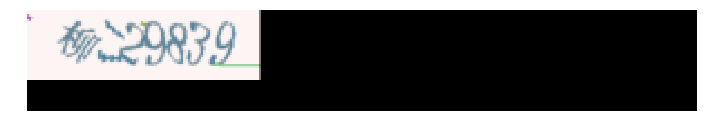

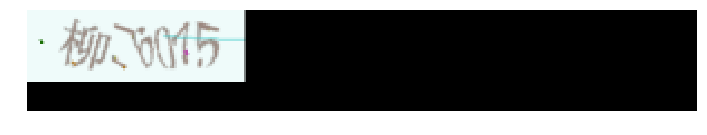

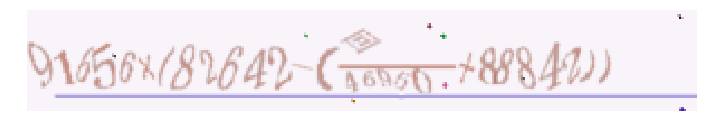

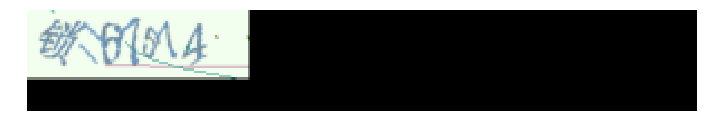

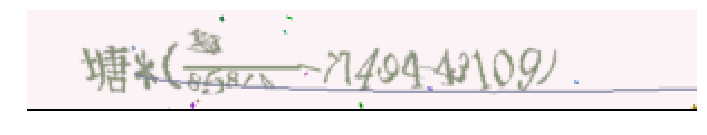

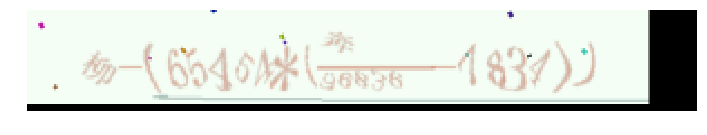

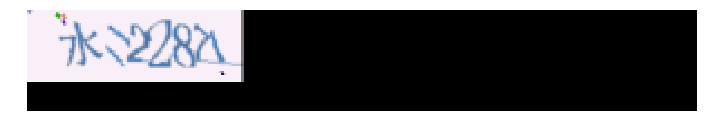

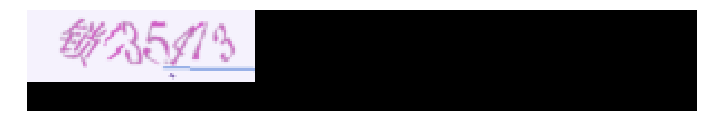

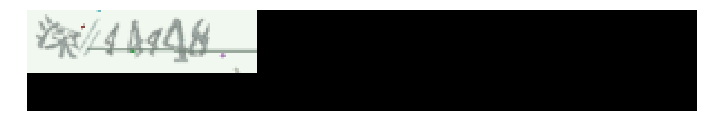

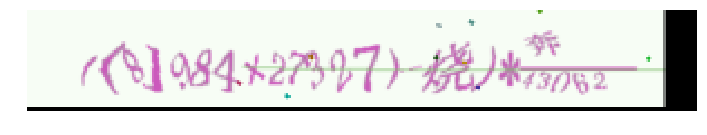

In [70]:
show_result(base_model, 10)

In [50]:
evaluate(base_model)

[ 0 17  5 11 13  8 12  9  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  3 11 14  6  8 11  1]
[ 0  9 12  6 15  9  2  0  0 14  9 12 10 11  3  8  6  9 11 15  1  1  3 34  5 10 15 14 12 14  7]
[18  5 11 14 12  6  9  3  0  7 10  9 10  8  2  0  7 13 15  6 15  2 14 14 10  6  7 14  9  1  1]


(0.7129586818544827, 0.8983222154841318, 0.40558659217877097)

In [ ]:
show_wrong_result(base_model, 10)

In [ ]:
%ls

In [54]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 300, 45, 3)    0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 298, 43, 64)   1792        the_input[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 149, 21, 64)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 147, 19, 128)  73856       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [61]:
model.save_weights('l2_first_54.wgt')

In [92]:
model.load_weights('l2_first_54.wgt')

In [95]:
model.save('l2_first_54.h5')